In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
#reading the dataset
#I've split the dataset to hold data for only one person and store it in a separate text file 
#to ensure consistency with respect to time

data = pd.read_csv("~/Desktop/NCSA_genomics/onePersonData.txt", sep="\t")
data.head()

,Display Time,GlucoseValue,subjectId,Internal Time
0,2014-02-03 03:42:12,93,1636-69-001,2016-02-03 00:05:23
1,2014-02-03 03:47:12,93,1636-69-001,2016-02-03 00:10:23
2,2014-02-03 03:52:12,93,1636-69-001,2016-02-03 00:15:23
3,2014-02-03 03:57:12,95,1636-69-001,2016-02-03 00:20:23
4,2014-02-03 04:02:12,96,1636-69-001,2016-02-03 00:25:23


In [3]:
#run only once
#dropping columns we don't need
data.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)

In [4]:
#Converting the Display Time to 'datetime' so that it can be used as an index
data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [5]:
data.head(10)


,Display Time,GlucoseValue
0,2014-02-03 03:42:12,93
1,2014-02-03 03:47:12,93
2,2014-02-03 03:52:12,93
3,2014-02-03 03:57:12,95
4,2014-02-03 04:02:12,96
5,2014-02-03 04:07:12,95
6,2014-02-03 04:12:12,95
7,2014-02-03 04:17:12,95
8,2014-02-03 04:22:12,96
9,2014-02-03 04:27:12,97


In [6]:
data = data.set_index(['Display Time'], drop=True)
data.head()

,GlucoseValue
Display Time,
2014-02-03 03:42:12,93
2014-02-03 03:47:12,93
2014-02-03 03:52:12,93
2014-02-03 03:57:12,95
2014-02-03 04:02:12,96


<Figure size 1440x576 with 0 Axes>

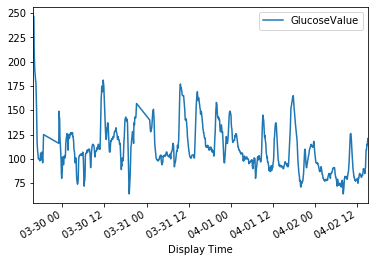

In [7]:
#plotting part of the data (last 1000 tuples) to see what it looks tike

plt.figure(figsize=(20, 8))
data.iloc[800:].plot(y='GlucoseValue')

<Figure size 1440x576 with 0 Axes>

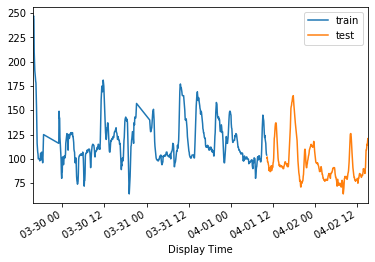

In [8]:
#splitting the data from a random datetime to create traning and test sets 
#again plotting the last 1000 values (part of which is the train set)

split_index = '2015-04-01 10:13:13'
train = data.loc[:split_index]
test = data.loc[split_index:]
test = test[1:]
plt.figure(figsize=(20, 8))
ax = train.iloc[800:].plot(y='GlucoseValue')
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [9]:
print(train)

                     GlucoseValue
Display Time                     
2014-02-03 03:42:12            93
2014-02-03 03:47:12            93
2014-02-03 03:52:12            93
2014-02-03 03:57:12            95
2014-02-03 04:02:12            96
...                           ...
2015-04-01 09:48:13           120
2015-04-01 09:58:13           116
2015-04-01 10:03:13           109
2015-04-01 10:08:13           105
2015-04-01 10:13:13           104

[1501 rows x 1 columns]


In [10]:
print(test)

                     GlucoseValue
Display Time                     
2015-04-01 10:18:13           101
2015-04-01 10:23:13           102
2015-04-01 10:28:13            97
2015-04-01 10:33:13            97
2015-04-01 10:38:13            96
...                           ...
2015-04-02 14:48:06           115
2015-04-02 14:53:06           114
2015-04-02 14:58:06           117
2015-04-02 15:03:06           121
2015-04-02 15:08:06           119

[345 rows x 1 columns]


In [11]:
#scaling => translates each feature individually such that it is in the given range on the training set
#to ensure the unit if our data is not a factor

scaler = MinMaxScaler(feature_range=(0, 1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [13]:
#Reshaping the data to work for an LSTM network

train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [14]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (1500, 1, 1)
Test shape:  (344, 1, 1)


In [15]:
# The LSTM networks creation and model compiling is similar with those of ANN’s.
# The LSTM has a visible layer with 1 input.
# A hidden layer with 7 LSTM neurons.
# An output layer that makes a single value prediction.
# The relu activation function is used for the LSTM neurons.
# The LSTM is trained for 100 epochs and a batch size of 1 is used.

lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=50, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0045
Epoch 2/50
1500/1500 [==============================] - 4s 3ms/step - loss: 8.4966e-04
Epoch 3/50
1500/1500 [==============================] - 3s 2ms/step - loss: 7.9040e-04
Epoch 4/50
1500/1500 [==============================] - 3s 2ms/step - loss: 8.2274e-04
Epoch 5/50
1500/1500 [==============================] - 4s 2ms/step - loss: 8.3017e-04
Epoch 00005: early stopping


In [16]:
#checking the R^2 value for training and test set
#R^2 tells us how much 'y' relies on 'x'
#the closer the values, the better our test set represents the training set

y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.967
The R2 score on the Test set is:	0.957


In [17]:
#estimating MSE
#calculated as the average of the squared forecast error values
#lower the better

lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('LSTM: %f'%lstm_test_mse)

344/344 [==============================] - 1s 2ms/step
LSTM: 0.000495


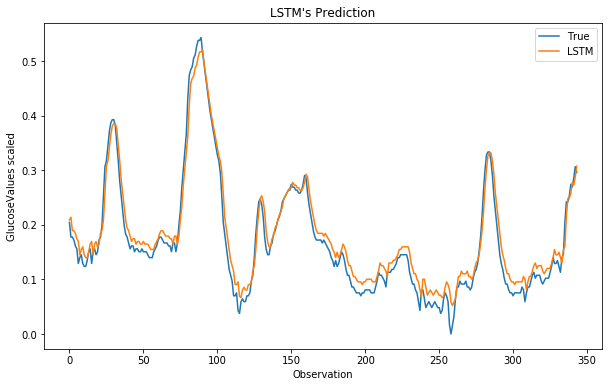

In [18]:
#plotting true values and lstm predicted values
#these are scaled values

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('GlucoseValues scaled')
plt.legend()
plt.show();

In [19]:
#inversing the scaling
lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
test_val = scaler.inverse_transform(y_test)


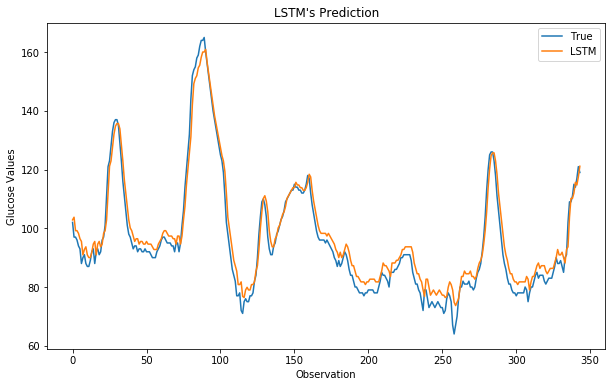

In [20]:
#plotting true values and lstm predicted values
#these are original values

plt.figure(figsize=(10, 6))
plt.plot(test_val, label='True')
plt.plot(lstm_pred, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Glucose Values')
plt.legend()
plt.show();